# Figure 1: Drought definitions

In [1]:
import climate_droughts_xr_funcs

# import things
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
print('xarray: %s' % xr.__version__)
print('numpy: %s' % np.__version__)
print('matplotlib: %s' % mpl.__version__)
print('pandas: %s' % pd.__version__)
print('pandas: %s' % pd.__version__)

xarray: 0.21.1
numpy: 1.22.4
matplotlib: 3.5.2
pandas: 1.4.1
pandas: 1.4.1


In [3]:
# change fonts
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['font.family'] = "sans-serif"
# mpl.rcParams['pdf.fonttype'] = 42 # change font from Arial (used in initial submission) to Helvetica

---

## Import file from BoM

Annoyingly, BoM has changed it so you can't just remotely load in the data. Downloading these stupid text files instead and renaming, because BoM REALLY needs to learn how to uniquely name files properly

In [4]:
# bom_precip_files

bom_annual_precip_eastern_url = 'http://www.bom.gov.au/web01/ncc/www/cli_chg/timeseries/rain/0112/eaus/latest.txt'
bom_southeastern_precip_url = 'http://www.bom.gov.au/web01/ncc/www/cli_chg/timeseries/rain/0112/seaus/latest.txt'
bom_southern_precip_url = 'http://www.bom.gov.au/web01/ncc/www/cli_chg/timeseries/rain/0112/saus/latest.txt'
bom_northern_precip_url = 'http://www.bom.gov.au/web01/ncc/www/cli_chg/timeseries/rain/0112/naus/latest.txt'
bom_mdb_precip_url = 'http://www.bom.gov.au/web01/ncc/www/cli_chg/timeseries/rain/0112/mdb/latest.txt'


In [5]:
bom_mdb_precip_path = 'files/BoM/rainfall_mdb.txt'
bom_mdb_precip = pd.read_csv(bom_mdb_precip_path, sep='  ',names=['time', 'precip'], skiprows=1)

bom_mdb_precip['year'] = bom_mdb_precip.time.astype(str).str[:4].astype(int)
bom_mdb_precip.set_index('year', inplace=True)
bom_mdb_precip

/var/folders/fm/9nwmq_gd47172_f70p3gk8nr0000gr/T/ipykernel_7832/4217475546.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  bom_mdb_precip = pd.read_csv(bom_mdb_precip_path, sep='  ',names=['time', 'precip'], skiprows=1)


,time,precip
year,,
1900,190001190012,413.61
1901,190101190112,364.38
1902,190201190212,256.42
1903,190301190312,528.07
1904,190401190412,449.23
...,...,...
2017,201701201712,402.30
2018,201801201812,290.67
2019,201901201912,229.85


In [21]:
# convert to xarray, since the definitions work on xarray already

ds_bom_mdb_precip = bom_mdb_precip.to_xarray()
ds_bom_mdb_precip['PRECT_mm'] = ds_bom_mdb_precip.precip
ds_bom_mdb_precip

<xarray.Dataset>
Dimensions:   (year: 122)
Coordinates:
  * year      (year) int64 1900 1901 1902 1903 1904 ... 2017 2018 2019 2020 2021
Data variables:
    time      (year) int64 190001190012 190101190112 ... 202101202112
    precip    (year) float64 413.6 364.4 256.4 528.1 ... 290.7 229.8 518.6 610.3
    PRECT_mm  (year) float64 413.6 364.4 256.4 528.1 ... 290.7 229.8 518.6 610.3

## Calculate droughts

Note: climatology is hardcoded to be 1900-2000 (inclusive)

In [22]:
def droughts_metrics_timeseries(ds):
    
    ds2 = ds.PRECT_mm
    ds3 = ds2.to_dataset()
    ff_precip_annual = ds3
    
    climatology = ff_precip_annual.where(ff_precip_annual.year <= 2000, drop=True)
    
    # get years that are drought vs not drought (1 for drought, 0 for no drought)
    ff_precip_annual['drought_years_2s2e'] = (climate_droughts_xr_funcs.get_drought_years_2S2E(ff_precip_annual.PRECT_mm, climatology.PRECT_mm.mean(dim='year'))).astype(int)
    ff_precip_annual['drought_years_median'] = ('year', (climate_droughts_xr_funcs.get_drought_years_below_threshold(ff_precip_annual.PRECT_mm, climatology.PRECT_mm.quantile(0.5, dim='year'))).astype(int))
    ff_precip_annual['drought_years_20perc'] = ('year', (climate_droughts_xr_funcs.get_drought_years_below_threshold(ff_precip_annual.PRECT_mm, climatology.PRECT_mm.quantile(0.2, dim='year'))).astype(int))
    ff_precip_annual['drought_years_120pc_2med'] = (climate_droughts_xr_funcs.get_drought_years_120perc_2median(ff_precip_annual.PRECT_mm, climatology.PRECT_mm.quantile(0.2, dim='year'), climatology.PRECT_mm.quantile(0.5, dim='year'))).astype(int)
    ff_precip_annual['drought_years_220pc_1med'] = (climate_droughts_xr_funcs.get_drought_years_below_start_end_thresholds(ff_precip_annual.PRECT_mm, climatology.PRECT_mm.quantile(0.2, dim='year'), climatology.PRECT_mm.quantile(0.5, dim='year'))).astype(int)

    # get overall length of droughts
    ff_precip_annual['droughts_2s2e'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_2s2e'])
    ff_precip_annual['droughts_median'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_median'])
    ff_precip_annual['droughts_20perc'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_20perc'])
    ff_precip_annual['droughts_120pc_2med'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_120pc_2med'])
    ff_precip_annual['droughts_220pc_1med'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_220pc_1med'])
    
    # get max length in this period
    ff_precip_annual['droughts_2s2e_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_2s2e, dim='year')
    ff_precip_annual['droughts_median_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_median, dim='year')
    ff_precip_annual['droughts_20perc_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_20perc, dim='year')
    ff_precip_annual['droughts_120pc_2med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_120pc_2med, dim='year')
    ff_precip_annual['droughts_220pc_1med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_220pc_1med, dim='year')
    
    # get mean length in this period
    ff_precip_annual['droughts_2s2e_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_2s2e, dim='year')
    ff_precip_annual['droughts_median_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_median, dim='year')
    ff_precip_annual['droughts_20perc_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_20perc, dim='year')
    ff_precip_annual['droughts_120pc_2med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_120pc_2med, dim='year')
    ff_precip_annual['droughts_220pc_1med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_220pc_1med, dim='year')
    
    # count how many individual events occur
    ff_precip_annual['droughts_2s2e_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_2s2e)
    ff_precip_annual['droughts_median_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_median)
    ff_precip_annual['droughts_20perc_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_20perc)
    ff_precip_annual['droughts_120pc_2med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_120pc_2med)
    ff_precip_annual['droughts_220pc_1med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_220pc_1med)
    
    ff_precip_annual['droughts_2s2e_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_2s2e, dim='year')
    ff_precip_annual['droughts_median_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_median, dim='year')
    ff_precip_annual['droughts_20perc_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_20perc, dim='year')
    ff_precip_annual['droughts_120pc_2med_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_120pc_2med, dim='year')
    ff_precip_annual['droughts_220pc_1med_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_220pc_1med, dim='year')
    
    ff_precip_annual['droughts_2s2e_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_2s2e', 'droughts_2s2e', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_median_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_median', 'droughts_median', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_20perc_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_20perc', 'droughts_20perc', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_120pc_2med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_120pc_2med', 'droughts_120pc_2med', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_220pc_1med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_220pc_1med', 'droughts_220pc_1med', ff_precip_annual.PRECT_mm.mean(dim='year'))

    ff_precip_annual['droughts_2s2e_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_2s2e', 'droughts_2s2e', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_median_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_median', 'droughts_median', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_20perc_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_20perc', 'droughts_20perc', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_120pc_2med_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_120pc_2med', 'droughts_120pc_2med', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_220pc_1med_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_220pc_1med', 'droughts_220pc_1med', ff_precip_annual.PRECT_mm.mean(dim='year'))
    
    return ff_precip_annual


In [23]:
ds_bom_mdb_precip_rc = droughts_metrics_timeseries(ds_bom_mdb_precip)

In [24]:
ds_bom_mdb_precip_rc

<xarray.Dataset>
Dimensions:                           (year: 122)
Coordinates:
  * year                              (year) int64 1900 1901 1902 ... 2020 2021
    quantile                          float64 0.5
Data variables: (12/41)
    PRECT_mm                          (year) float64 413.6 364.4 ... 518.6 610.3
    drought_years_2s2e                (year) int64 1 1 1 1 1 1 1 ... 1 1 1 1 0 0
    drought_years_median              (year) int64 1 1 1 0 1 1 0 ... 0 1 1 1 0 0
    drought_years_20perc              (year) int64 0 1 1 0 0 0 0 ... 0 0 1 1 0 0
    drought_years_120pc_2med          (year) int64 0 1 1 1 1 1 1 ... 1 1 1 1 0 0
    drought_years_220pc_1med          (year) int64 0 1 1 0 0 0 0 ... 0 0 1 1 0 0
    ...                                ...
    droughts_220pc_1med_intensity     (year) float64 nan nan -160.1 ... nan nan
    droughts_2s2e_severity            (year) float64 nan nan nan ... nan nan
    droughts_median_severity          (year) float64 nan nan -377.2 ... nan nan
    droughts_20perc_severity          (year) float64 nan nan -320.3 ... nan nan
    droughts_120pc_2med_severity      (year) float64 nan nan nan ... nan nan
    droughts_220pc_1med_severity      (year) float64 nan nan -320.3 ... nan nan

---
# Figure
Plot the different drought definitions

In [10]:
drought_years_median = xr.where(ds_bom_mdb_precip_rc.drought_years_median > 0, 1, np.nan)
drought_years_2s2e = xr.where(ds_bom_mdb_precip_rc.drought_years_2s2e > 0, 1, np.nan)
drought_years_20perc = xr.where(ds_bom_mdb_precip_rc.drought_years_20perc > 0, 1, np.nan)
drought_years_120pc_2med = xr.where(ds_bom_mdb_precip_rc.drought_years_120pc_2med > 0, 1, np.nan)
drought_years_220pc_1med = xr.where(ds_bom_mdb_precip_rc.drought_years_220pc_1med > 0, 1, np.nan)

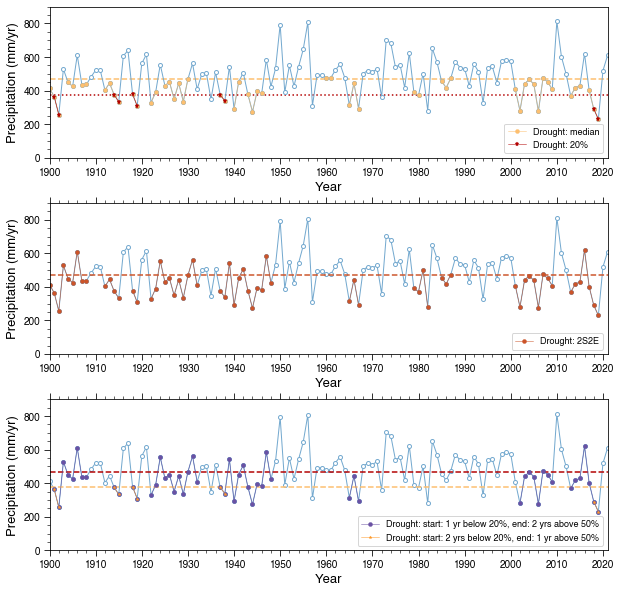

In [26]:
df = ds_bom_mdb_precip_rc
drought_years_plot = df * (df.droughts_2s2e / df.droughts_2s2e)

# set things...
col_median = '#fdbf6f'
col_20perc = '#b30000'
col_2s2e = '#CC5429'
col_precip = '#74a9cf'

xmin = 1900
xmax = 2021

ymin = 0
ymax = 900

xticks = np.arange(1900, 2030, 10)

# font sizes
font_labelsize = 13
font_ticksize = 10
font_legend = 9

markersize = 4

linewidth_hline = 1.5
linewidth_precip = 1

# ------------------------
# --- plot
fig = plt.figure(figsize=(10, 10))

# ------------------------
# first subplot - % based defs
ax = fig.add_subplot(3, 1, 1)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
# precip
plt.plot(df.year, df.PRECT_mm, marker='o', linewidth=linewidth_precip, markersize=markersize,
         markeredgewidth=1, markerfacecolor='white', color=col_precip, zorder=1)

# median droughts
plt.plot(df.year, drought_years_median * df.PRECT_mm, 
         marker='o', markerfacecolor=col_median, markersize=markersize, 
         linewidth=0.5, markeredgewidth=0.4, color=col_median, label='Drought: median')

plt.hlines(df.PRECT_mm.quantile(0.5, dim='year'), xmin, xmax, linewidth=linewidth_hline, 
           color=col_median, linestyle='--', zorder=0)
# plt.plot(df.year, df.PRECT_mm, marker='o', linewidth=1.5,
#          markeredgewidth=1.5, markerfacecolor='white', color='#2166ac', label='Precipitation')

# 20 %
plt.plot(df.year, drought_years_20perc * df.PRECT_mm, 
         marker='*', color=col_20perc, markersize=5, linewidth=0.5, markeredgewidth=0.3, 
         label='Drought: 20%')

plt.hlines(df.PRECT_mm.quantile(0.2, dim='year'), xmin, xmax, 
           linewidth=linewidth_hline, color=col_20perc, linestyle=':', zorder=0)

# ---- make the plot a little nicer
plt.minorticks_on()
plt.xticks(xticks, fontsize=font_ticksize)
plt.xlim(xmin, xmax)
plt.yticks(np.arange(0, 1000, 200),fontsize=font_ticksize)
plt.ylim(ymin, ymax)
plt.tick_params(which='minor', labelsize=font_ticksize, length=3)
plt.tick_params(which='major', labelsize=font_ticksize, length=6) 
plt.xlabel('Year', fontsize=font_labelsize)
plt.ylabel('Precipitation (mm/yr)', fontsize=font_labelsize)

plt.legend(fontsize=font_legend, loc='lower right')

# ------------------------
# ---- second subplot - 2s2e
ax = fig.add_subplot(3, 1, 2)
# precip
plt.plot(df.year, df.PRECT_mm, marker='o', linewidth=linewidth_precip, markeredgewidth=1, markersize=markersize,
         markerfacecolor='white', color=col_precip)

# 2s2e
plt.hlines(df.PRECT_mm.mean(dim='year'), xmin, xmax, linewidth=linewidth_hline, color=col_2s2e, linestyle='--')
plt.plot(df.year, drought_years_2s2e * df.PRECT_mm, marker='o', color=col_2s2e, markeredgewidth=0.4,
         markersize=markersize, linewidth=0.5, label='Drought: 2S2E')

plt.minorticks_on()
plt.xticks(xticks, fontsize=font_ticksize)
plt.xlim(xmin, xmax)
plt.yticks(np.arange(0, 1000, 200), fontsize=font_ticksize)
ax.xaxis.set_ticks_position('both')
plt.ylim(ymin,ymax)
plt.tick_params(which='minor', labelsize=font_ticksize, length=3)
plt.tick_params(which='major', labelsize=font_ticksize, length=6) 
plt.xlabel('Year', fontsize=font_labelsize)
plt.ylabel('Precipitation (mm/yr)', fontsize=font_labelsize)

plt.legend(fontsize=font_legend, loc='lower right')

# ------------------------
# ---- third subplot - start and end with diferent thresholds
ax = fig.add_subplot(3,1,3)
plt.plot(df.year, df.PRECT_mm, marker='o', linewidth=linewidth_precip, markeredgewidth=1, markersize=markersize,
         markerfacecolor='white', color=col_precip)

# 2s2e
plt.hlines(df.PRECT_mm.quantile(0.2, dim='year'), xmin, xmax, linewidth=linewidth_hline, color=col_median, linestyle='--')
plt.hlines(df.PRECT_mm.quantile(0.5, dim='year'), xmin, xmax, linewidth=linewidth_hline, color=col_20perc, linestyle='--')

plt.plot(df.year, drought_years_120pc_2med * df.PRECT_mm, marker='o', color='#6a51a3', markeredgewidth=0.4,
         markersize=markersize, linewidth=0.5, label='Drought: start: 1 yr below 20%, end: 2 yrs above 50%')

plt.plot(df.year, drought_years_220pc_1med * df.PRECT_mm, marker='*', color='#fe9929', markeredgewidth=0.4,
         markersize=markersize - 1, linewidth=0.5, label='Drought: start: 2 yrs below 20%, end: 1 yr above 50%')

plt.minorticks_on()
plt.xticks(xticks, fontsize=font_ticksize)
plt.xlim(xmin, xmax)
plt.yticks(np.arange(0, 1000, 200),fontsize=font_ticksize)
ax.xaxis.set_ticks_position('both')
plt.ylim(ymin,ymax)
plt.tick_params(which='minor', labelsize=font_ticksize, length=3)
plt.tick_params(which='major', labelsize=font_ticksize, length=6) 
plt.xlabel('Year', fontsize=font_labelsize)
plt.ylabel('Precipitation (mm/yr)', fontsize=font_labelsize)

plt.legend(fontsize=font_legend, loc='lower right')

# plt.savefig('/Users/nickywright/PostDoc/Manuscripts/Wright_etal_drought-frequencies/Figure1/Fig1_drought_defs.pdf', dpi=300, bbox_inches='tight')
plt.show()

Now use illustrator to make the other modifications and label....

---

# OLD plots

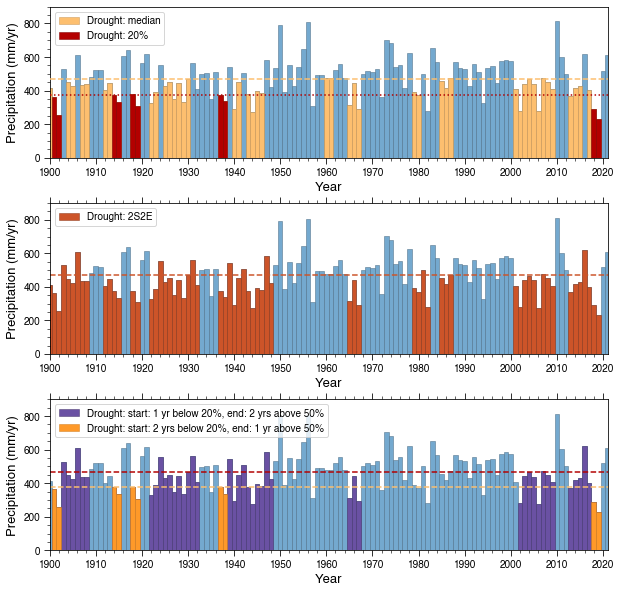

In [12]:
df = ds_bom_mdb_precip_rc
drought_years_plot = df * (df.droughts_2s2e / df.droughts_2s2e)

col_median =  '#fdbf6f' 
col_20perc = '#b30000' 
col_2s2e = '#CC5429'
col_precip= '#74a9cf'

xmin=1900
xmax=2021

ymin=0
ymax=900

xticks=np.arange(1900,2030,10)
# font sizes
font_labelsize=13
font_ticksize=10
font_legend=10

markersize=4

linewidth_hline=1.5
linewidth_precip=0.5
width=1

# --- start plotting
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(3,1,1)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.bar(df.year, df.PRECT_mm, width=width, linewidth=linewidth_precip, color=col_precip, edgecolor='#4A6C85',  zorder=1)

# median droughts

plt.bar(df.year, drought_years_median * df.PRECT_mm,  width=width,edgecolor='#CC9A5A',
         linewidth=0.5, color=col_median, label='Drought: median')


plt.hlines(df.PRECT_mm.quantile(0.5, dim='year'), xmin, xmax, linewidth=linewidth_hline, 
           color=col_median, linestyle='--', zorder=3)
# plt.plot(df.year, df.PRECT_mm, marker='o', linewidth=1.5,
#          markeredgewidth=1.5, markerfacecolor='white', color='#2166ac', label='Precipitation')

# 20 %

plt.bar(df.year, drought_years_20perc * df.PRECT_mm, 
         color=col_20perc, width=width, edgecolor='#820000',linewidth=linewidth_precip,
         label='Drought: 20%')

plt.hlines(df.PRECT_mm.quantile(0.2, dim='year'), xmin, xmax, 
           linewidth=linewidth_hline, color=col_20perc, linestyle=':', zorder=3)


plt.minorticks_on()
plt.xticks(xticks, fontsize=font_ticksize)
plt.xlim(xmin, xmax)
plt.yticks(np.arange(0,1000,200), fontsize=font_ticksize)

plt.ylim(ymin,ymax)

plt.legend(fontsize=font_legend, loc='upper left')

plt.tick_params(which = 'minor', labelsize=font_ticksize, length=3)
plt.tick_params(which = 'major', labelsize=font_ticksize, length=6) 

plt.xlabel('Year', fontsize=font_labelsize)
plt.ylabel('Precipitation (mm/yr)', fontsize=font_labelsize)

# -----------------------
ax = fig.add_subplot(3,1,2)
plt.bar(df.year, df.PRECT_mm, width=width, linewidth=linewidth_precip, color=col_precip, edgecolor='#4A6C85')


# 2s2e

plt.bar(df.year, drought_years_2s2e * df.PRECT_mm,  width=width, edgecolor='#8F3B1D',linewidth=linewidth_precip,
         color=col_2s2e, label='Drought: 2S2E')
plt.hlines(df.PRECT_mm.mean(dim='year'), xmin, xmax, linewidth=linewidth_hline, color=col_2s2e, linestyle='--')
plt.minorticks_on()
plt.xticks(xticks, fontsize=font_ticksize)
plt.xlim(xmin, xmax)
plt.yticks(np.arange(0,1000,200), fontsize=font_ticksize)
ax.xaxis.set_ticks_position('both')
plt.ylim(ymin,ymax)

plt.legend(fontsize=font_legend, loc='upper left')

plt.tick_params(which = 'minor', labelsize=font_ticksize, length=3)
plt.tick_params(which = 'major', labelsize=font_ticksize, length=6) 

plt.xlabel('Year', fontsize=font_labelsize)
plt.ylabel('Precipitation (mm/yr)', fontsize=font_labelsize)


ax = fig.add_subplot(3,1,3)
plt.bar(df.year, df.PRECT_mm,linewidth=linewidth_precip,color=col_precip, width=width, edgecolor='#4A6C85')

# 2med etc
plt.hlines(df.PRECT_mm.quantile(0.2, dim='year'), xmin, xmax, linewidth=linewidth_hline, color=col_median, linestyle='--')
plt.hlines(df.PRECT_mm.quantile(0.5, dim='year'), xmin, xmax, linewidth=linewidth_hline, color=col_20perc, linestyle='--')

plt.bar(df.year, drought_years_120pc_2med * df.PRECT_mm, width=width, color='#6a51a3', linewidth=linewidth_precip, edgecolor='#493870', label='Drought: start: 1 yr below 20%, end: 2 yrs above 50%')

plt.bar(df.year, drought_years_220pc_1med * df.PRECT_mm, width=width, color='#fe9929', linewidth=linewidth_precip, edgecolor='#D48122',label='Drought: start: 2 yrs below 20%, end: 1 yr above 50%')

plt.minorticks_on()
plt.xticks(xticks, fontsize=font_ticksize)
plt.xlim(xmin, xmax)
plt.yticks(np.arange(0,1000,200), fontsize=font_ticksize)
ax.xaxis.set_ticks_position('both')
plt.ylim(ymin,ymax)

plt.legend(fontsize=font_legend, loc='upper left')

plt.tick_params(which = 'minor', labelsize=font_ticksize, length=3)
plt.tick_params(which = 'major', labelsize=font_ticksize, length=6) 

plt.xlabel('Year', fontsize=font_labelsize)
plt.ylabel('Precipitation (mm/yr)', fontsize=font_labelsize)


# plt.savefig('/Users/nickywright/PostDoc/Manuscripts/Wright_etal_drought-frequencies/Figure1/Fig1_drought_defs_bar.pdf', dpi=300, bbox_inches='tight')
plt.show()